# レジスタ割り当て最適化
Amplify を用いたレジスタ割り当ての最適化について解説します．

## レジスタ割り当て最適化問題とは
レジスタ割り当て最適化問題とは，コンパイラが変数に対してレジスタを割り当てる際に，変数同士ができるだけ同一のレジスタを使用しないように，レジスタの割り当てを決定する問題です．

レジスタとは，コンピュータが計算を行う際に変数の値を一時的に保持しておくための記憶素子です．レジスタは何度も計算に使われる変数の値を保持しておくことで，変数の値をいちいちメモリから探す手間を省き，計算を速くすることができます．

しかし，レジスタの本数には限りがあるので，保持しておける変数の数にも限りがあります．
もしレジスタがいっぱいの状態で，新たに変数をレジスタに格納しようとした場合，どこかのレジスタに格納されていた変数が溢れることになります．これをレジスタスピルと呼びます．
溢れた変数が，計算の途中でもう一度必要になった場合，もう一度レジスタに格納し直す必要があり，無駄な処理が発生することになります．

そのため，計算を高速化するためには，レジスタスピルが発生しないように，変数をレジスタに割り当てる必要があります．

## グラフ彩色問題との関連性
レジスタ割り当て最適化問題は，グラフ彩色問題の応用例としても知られています．

グラフ彩色問題の説明はオンラインデモにもあるので割愛しますが，レジスタ割り当てに応用する場合には，変数をノードとして扱い，生存期間が重なる変数同士にエッジを与えます．この時，レジスタ数分の色を用意し，なるべくエッジで結ばれた変数同士は同じ色にならないように，色付けを行うことになります．

- 変数の数：𝑁，レジスタの数：𝑅
- 変数𝑖をレジスタ𝒓に割り当てる時：𝑞_(𝑖, 𝑟)=1，割り当てない時：𝑞_(𝑖, 𝑟)=0
- 𝐸\[𝑖\]： 変数 𝑖 と生存期間が重なる変数の集合
- 𝐴\[𝑖\]： 変数 𝑖 が割り当て可能なレジスタの集合

ここまでの制約条件は，以下のようになります．

**制約条件**

- ある変数が割り当てられるレジスタは一つのみ

$$
    \sum_{r = 0}^{R-1}{ q_{i,r} } = 1 \quad i \in \left\{0, 1, \cdots, N - 1 \right\}
$$

- 生存期間の重なる変数同士は，別のレジスタに割り当て

$$
    \sum_{j \in E[i]}{ q_{i,r} q_{j,r} } = 0 \quad r \in \left\{0, 1, \cdots, R - 1 \right\}
$$

レジスタ割り当て最適化問題の場合には，ある変数が割り当て可能なレジスタに制限があります．これは，変数の型がによっては，割り当てることができないレジスタが存在するためです．
そのため，さらにもう一つの制約が必要となります．

**制約条件**

- 全ての変数は，それぞれが割り当て可能なレジスタから割り当てを行う

$$
    \sum_{r \notin A[i]}{ q_{i,r} } = 0 \quad i \in \left\{0, 1, \cdots, N - 1 \right\}
$$

## IsingRegisterAllocator
私たちは，レジスタ割り当て最適化問題を Amplify を用いて解くためのライブラリ IsingRegisterAllocator を作成しました．

ここからは，このライブラリを使って，実際にレジスタ割り当てを行ってみます．

In [1]:
%matplotlib inline
from IsingRegisterAllocator import get_solution_limited_unit
from IsingRegisterAllocator.util import convert, draw_graph, config

## MonteC

ベンチマークを読み込みます．

In [2]:
MonteC = convert.load_all_out_allocated("../benchmarks/MonteC/")

ベンチマークの中身は．上から
- interference :  生存期間の重なる変数のリスト．E\[i\]に相当
- limitation :    変数が割り当て可能なレジスタ．A\[i\]に相当
- num_registers : 総レジスタ数

In [3]:
MonteC

{'interference': [[3, 5, 6, 7, 8],
  [5, 6],
  [],
  [0, 4, 7, 8],
  [3],
  [0, 1, 6],
  [0, 1, 5],
  [0, 3],
  [0, 3],
  []],
 'limitation': {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  2: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
  3: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
  4: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
  5: [1, 2, 9, 10, 11, 12],
  6: [31, 32, 33, 34, 35, 36],
  7: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
  8: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
  9: [37, 38, 31, 32, 33, 34, 39, 40, 41, 35, 36, 42, 43, 44, 45]},
 'num_registers': 46}

割り当て前の干渉グラフ

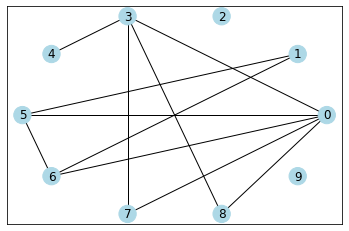

In [4]:
draw_graph(MonteC["interference"])

Amplifyで解を求めます

In [5]:
solution = get_solution_limited_unit(**MonteC, token=config.AMPLIFY_TOKEN)

In [6]:
solution

array([11,  6, 21, 18, 25, 10, 35, 16, 29, 38])

割り当て結果を考慮した干渉グラフの可視化

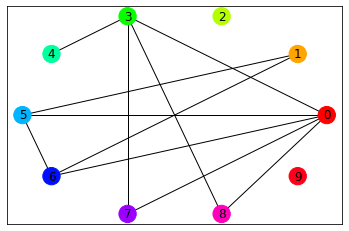

In [7]:
draw_graph(MonteC["interference"], list(solution))

## BubbleSort

In [8]:
BubbleSort = convert.load_all_out_allocated("../benchmarks/BubbleSort/")

In [9]:
BubbleSort

{'interference': [[1, 2, 3, 4, 6, 7, 9, 10, 11],
  [0, 4, 6, 7, 9, 10, 11],
  [0, 3, 4, 6, 7, 9, 10, 11],
  [0, 2, 4, 6, 7, 9, 10, 11],
  [0, 1, 2, 3, 6, 7, 9, 10, 11],
  [6, 7, 9, 10, 11],
  [0, 1, 2, 3, 4, 5, 7, 9, 10, 11],
  [0, 1, 2, 3, 4, 5, 6, 9, 10, 11],
  [9, 11],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11],
  [0, 1, 2, 3, 4, 5, 6, 7, 9, 11],
  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
  []],
 'limitation': {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  1: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
  2: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
  3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  4: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
  5: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  6: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  7: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  8: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
  9: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 1

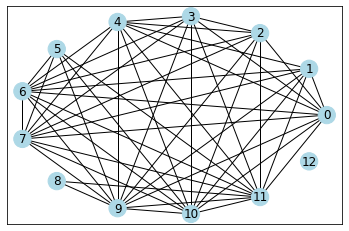

In [10]:
draw_graph(BubbleSort["interference"])

In [12]:
solution = get_solution_limited_unit(**BubbleSort, token=config.AMPLIFY_TOKEN)

In [13]:
solution

array([ 3, 23, 25,  9, 20, 13,  1,  4, 18, 12,  5, 11, 27])

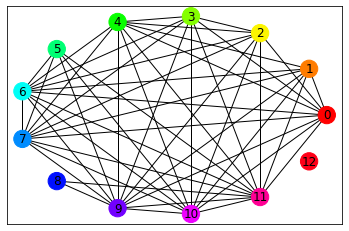

In [14]:
draw_graph(BubbleSort["interference"], list(solution))

## Simpson

In [15]:
Simpson = convert.load_all_out_allocated("../benchmarks/Simpson/")

In [16]:
Simpson

{'interference': [[1, 2, 3, 8, 9, 10, 11, 12, 14, 16, 17, 19],
  [0, 7, 8, 9, 10, 11, 16, 19],
  [0, 10, 11, 19],
  [0, 7, 8, 9, 10, 11, 16, 19],
  [7, 8, 9, 10, 11, 16, 19],
  [7, 8, 9, 10, 11, 16, 19],
  [12, 13],
  [1, 3, 4, 5],
  [0, 1, 3, 4, 5],
  [0, 1, 3, 4, 5],
  [0, 1, 2, 3, 4, 5],
  [0, 1, 2, 3, 4, 5],
  [0, 6],
  [6],
  [0, 18],
  [19],
  [0, 1, 3, 4, 5],
  [0],
  [14],
  [0, 1, 2, 3, 4, 5, 15]],
 'limitation': {0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
  1: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
  2: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
  3: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
  4: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
  5: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
  6: [31, 32, 33, 34, 35, 36],
  7: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
  8: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,

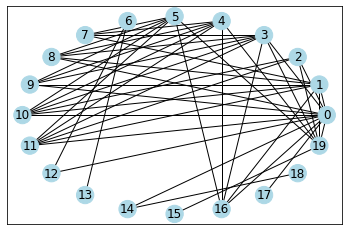

In [17]:
draw_graph(Simpson["interference"])

In [18]:
solution = get_solution_limited_unit(**Simpson, token=config.AMPLIFY_TOKEN)

In [19]:
solution

array([ 0, 19, 29, 15, 25, 16, 31, 22, 26, 27, 18, 27,  3, 36, 16, 15, 26,
        9, 29, 24])

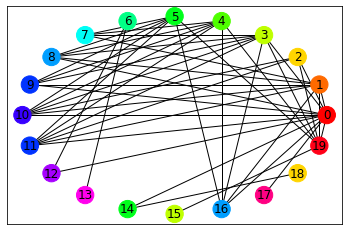

In [20]:
draw_graph(Simpson["interference"], list(solution))